In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer #Tokenize words to numerical format
from tensorflow.keras.preprocessing.sequence import pad_sequences #Every word must have same length for matrix representation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [0]:
import numpy as np
import pandas as pd
from numpy import array
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis

In [0]:
data = pd.read_csv('/content/drive/My Drive/fake.csv')
data.shape

(12999, 20)

In [0]:
data.head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [0]:
data.tail(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.0,NaN,40,32,0,0,0,bs
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.0,NaN,40,32,0,0,0,bs
12996,6995d1aa9ac99926106489b14b5530e85358059a,4,major major maj...,2016-10-27T00:06:00.000+03:00,NaN,I'm waiting for the one that puts a pussy on m...,english,2016-10-27T00:37:46.244+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.0,NaN,40,32,0,0,0,bs
12997,7de8ae90eee164eb756db6c8a3772288e11d7a94,5,beemasters,2016-10-27T00:09:00.000+03:00,NaN,$4 Billion even after they are known to be kee...,english,2016-10-27T00:37:46.247+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.0,NaN,40,32,0,0,0,bs
12998,dabef7095b7d9dae6eb0d83c4cbb40b85efd7ae5,6,i&#039;m-confused,2016-10-27T00:09:00.000+03:00,NaN,of course - how else would they disceminate te...,english,2016-10-27T00:37:46.260+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.0,NaN,40,32,0,0,0,bs


In [0]:
# Lets create y_label i.e Spam or not by Creating a Bias
# Any article with spam level >0.2 is marked as spam

y_data = []
for e in data['spam_score']:
  if e > 0.2:
    y_data.append(1)
  else:
    y_data.append(0)

In [0]:
len(y_data)

12999

In [0]:
count_0 = 0
count_1 = 0
for e in y_data:
  if(e == 1):
    count_1 = count_1 + 1
  else:
    count_0 = count_0 + 1

In [0]:
print(count_0)

12499


In [0]:
print(count_1)

500


In [0]:
# X_data is combination of text and title because content + title both can play a pivotal role in determining label

X_data = data['text'] + data['title']

In [0]:
X_data.shape

(12999,)

In [0]:
X_data[10000]

"Experts Recommend Breaking Down Crushing Defeats Into Smaller, More Manageable Failures Close Vol 50 Issue 20 · Lifestyle \nSANTA BARBARA, CA—Offering advice to those who feel overwhelmed at the thought of becoming massive failures, a group of experts reported this week that the best way to approach a crippling defeat is to break it down into a set of smaller and more manageable setbacks. “The key to failing on a monumental scale is to take life one small misstep at a time,” life coach Jack V. Royce told reporters, emphasizing that people who hit absolute rock bottom seldom get there overnight. “Just start with a couple of minor fuckups and then build off that. It’s all about working through your long, humiliating downward spiral in workable increments: botch this, flub that, make a wreck of something else—and then, before you know it, you’re well on your way to being totally screwed.” Royce added that it’s also helpful every now and then to stop, take stock of your situation, and rea

# Cleaning and Tokenizing X_data and y_data

In [0]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Data Pre-Processing(Treating Symbols and Stopwords Present in Data)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') #These Symbols will be replaced with Space
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')         #These Symbols will be Removed from Text
STOPWORDS = set(stopwords.words('english')) 

In [0]:
#Text Cleaning Functions

def string_form(value):
    return str(value)

def clean_text(text):
   
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()  #LowerCase Text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) #Replace Certain Symbols by Space in Text
    text = BAD_SYMBOLS_RE.sub('', text) #Delete Certain Symbols from Text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) #Remove Stopwords from Text
    return text

In [0]:
# Text Pre-processing and cleaning operations

X_data = X_data.apply(string_form)
X_data = X_data.apply(clean_text)

In [0]:
# Let us Remove all nan values

X_data_final = []
y_data_final = []

for e in range(len(X_data)):
  if(X_data[e] != 'nan'):
    X_data_final.append(X_data[e])
    y_data_final.append(y_data[e])

In [0]:
len(X_data_final)

12273

In [0]:
len(y_data_final)

12273

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data_final)

In [0]:
# Let's see all the words tokenized

vocab = tokenizer.index_word
vocab

In [0]:
#We saw the tokenization of words
#Now we will get length of vocabulary then do embedding
vocab_size = len(tokenizer.word_index) + 1
vocab_size

171533

In [0]:
# We have a staggering 171533 distinct words after text cleaning

In [0]:
#We have 28711 unique words
encoded_text = tokenizer.texts_to_sequences(X_data_final)

In [0]:
#This is text data tokenized and as present in dataset, i.e as sentences
encoded_text

In [0]:
len(encoded_text)

12273

# Finding Average Length of an article

In [0]:
# We want to keep articles which have minimum 100 words and maximum 1500 words to prevent under-fitting and over-fitting

min = 100
max = 1500
count = 0
for e in encoded_text:
  if(len(e) > min and len(e) < max):
    count = count + 1
  
count

9461

In [0]:
# By trial and error it is observed that 9461 artciles out of 12773 fall between 100 and 1500 words
# Hence, we pad sequences to length 1500 to take care of bulk of the articles

In [0]:
#Max length of any text sequence in the dataset

max_length = 1500
X = pad_sequences(encoded_text, maxlen = max_length, padding = 'post')

In [0]:
print(X)

[[  1230    415     51 ...      0      0      0]
 [   712    173   2946 ...      0      0      0]
 [   838     17    922 ...      0      0      0]
 ...
 [  1373      7      3 ...      0      0      0]
 [171521    896    687 ...      0      0      0]
 [   896    687     15 ...      0      0      0]]


In [0]:
X.shape

(12273, 1500)

In [0]:
X[0]

array([1230,  415,   51, ...,    0,    0,    0], dtype=int32)

In [0]:
# Now finally we have X as cleaned, tokenized and padded X_data and y_data_final as y_data

In [0]:
# Now that we have X_data and y_data we will split them

from sklearn.model_selection import train_test_split
X_train, X_test, y_train , y_test = train_test_split(X,y_data_final, test_size = 0.2)

In [0]:
#Since the Dataset is Un-Balanced we need to apply Over-Sampling
#We need to tokenize and pad X_train and X_test before applying smote

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27, ratio = 1.0)
x_train_over, y_train_over = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# Let us count classes in y_train_over

count1 = 0
count0 = 0
for e in y_train_over:
  if e == 1:
    count1 = count1 + 1
  elif e == 0:
    count0 = count0 + 1

In [0]:
# Now we can see that both classes are balanced

print(count0,count1)

9456 9456


In [0]:
y_train_over.shape

(18912,)

In [0]:
# now finally classes are balanced

# Using Glove Vectors


In [0]:
glove_vectors = dict()

In [0]:
file = open('/content/drive/My Drive/glove.twitter.27B.25d.txt',encoding = 'utf-8')

for line in file:
  values = line.split()
  word = values[0]
  vectors = np.asarray(values[1:])
  glove_vectors[word] = vectors
file.close()

In [0]:
#There are 1193514 words with their vectors here
len(glove_vectors.keys())

1193514

In [0]:
#Global Vector Representation of word him
glove_vectors.get('him')

array(['-0.33672', '0.66134', '0.2701', '0.92599', '-0.73521', '-0.71368',
       '0.58595', '0.051236', '-0.96658', '0.17068', '-0.64852', '1.0565',
       '-5.6538', '-0.34841', '0.21554', '-0.16274', '0.39151', '-1.0089',
       '-0.18985', '-1.0105', '0.16037', '0.59365', '0.53513', '-0.13699',
       '-0.84796'], dtype='<U8')

In [0]:
# Creating a word and correspoding vector matrix and finding out which words arent present in glove
word_vector_matrix = np.zeros((vocab_size, 25))
unavailable = 0

for word, index in tokenizer.word_index.items():
  vector = glove_vectors.get(word)
  if vector is not None:
    word_vector_matrix[index] = vector
  else:
    unavailable = unavailable + 1
    print(word)

In [0]:
unavailable

96005

In [0]:
# Out of 171,533 words , 96005 are unavailable in glove. This can cause potential problem
# This problem can be removed by using customised word2vec modelling using all these words

In [0]:
#Now we will search for vectors of words in our dataset and build model

In [0]:
X

array([[  1230,    415,     51, ...,      0,      0,      0],
       [   712,    173,   2946, ...,      0,      0,      0],
       [   838,     17,    922, ...,      0,      0,      0],
       ...,
       [  1373,      7,      3, ...,      0,      0,      0],
       [171521,    896,    687, ...,      0,      0,      0],
       [   896,    687,     15, ...,      0,      0,      0]], dtype=int32)

In [0]:
vec_size = 25
max_length = 1500
#The glove vectors are represented in 25 dimension

In [0]:
import tensorflow as tf

In [0]:
#Let's make a keras model

model = tf.keras.Sequential()
#Now we will add embedding layer telling how many words are there and which weights to use(the glove ones)
model.add(Embedding(vocab_size, vec_size, input_length = max_length, weights = [word_vector_matrix], trainable = False))

model.add(Conv1D(128, 8 ,activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Conv1D(64, 4, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(32, 2, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(16, activation = 'relu' ))
model.add(Dense(8,activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 25)          4288325   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1493, 128)         25728     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 746, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 746, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 743, 64)           32832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 371, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 371, 64)          

In [0]:
# Adam Optimizer was used for Experiment
adam = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

In [0]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
#Training the Model(Epochs can be tuned to get more Accuracy)
epochs = 5
batch_size = 15

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data = (X_test, y_test))

Epoch 1/5
655/655 [==============================] - 114s 174ms/step - loss: 0.1657 - accuracy: 0.9631 - val_loss: 0.1634 - val_accuracy: 0.9613
Epoch 2/5
655/655 [==============================] - 111s 169ms/step - loss: 0.1614 - accuracy: 0.9631 - val_loss: 0.1664 - val_accuracy: 0.9613
Epoch 3/5
655/655 [==============================] - 111s 169ms/step - loss: 0.1580 - accuracy: 0.9631 - val_loss: 0.1645 - val_accuracy: 0.9613
Epoch 4/5
655/655 [==============================] - 111s 169ms/step - loss: 0.1510 - accuracy: 0.9629 - val_loss: 0.1645 - val_accuracy: 0.9613
Epoch 5/5
655/655 [==============================] - 111s 169ms/step - loss: 0.1437 - accuracy: 0.9629 - val_loss: 0.1581 - val_accuracy: 0.9613


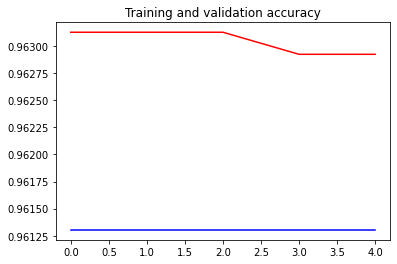

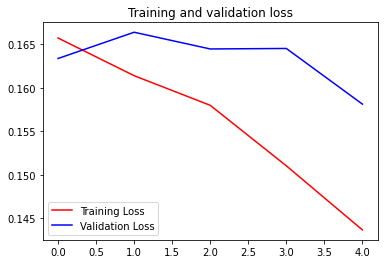

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred.shape

(2455, 1)

In [0]:
# Creating a bias for final prediction

y_predfinal = []
for e in y_pred:
  if e > 0.2:
    y_predfinal.append(1)
  else:
    y_predfinal.append(0)
  
y_predfinal = np.array(y_predfinal)
y_predfinal.shape

(2455,)

In [0]:
y_test.shape

(2455,)

In [0]:
# The model Detects 2357 real News articles out of 2451 real Articles
# The model Detects 1 fake article out of 4 fake articles

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_predfinal)

array([[2357,    3],
       [  94,    1]])

In [0]:
# The above result will be our baseline, we will train own word2vec model and add attention to improve results